## Import packages

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot

sys.path.insert(0, '..')

from pybandstructure import *
import graphene as gr

## Graphene and simulation parameters

In [2]:
#distances in nm, energies in eV
#################### band-structure parameters #######################################
k_cutoff = 1. #nm^-1 energies are accurate up to +-hv_F * k_cutoff
q_cutoff = 0.1
hv_F = 0.658  # \hbar v_F in eV*nm #1.0545919(80) x 10-27=\hbar [erg s]
n_sites = 60 # integer 
################### these parameters can be changed later ############################
density = 0. # nm^-2
temperature = 0.026 # eV k_B T
eta = 0.100 # eV energy broadening \hbar/tau 

## Define geometry and sampling of k space

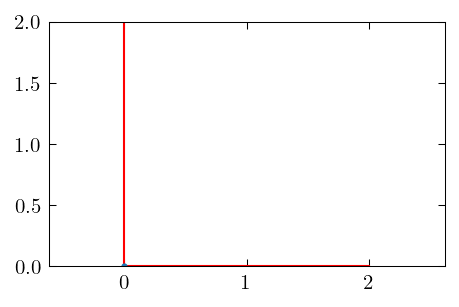

In [3]:
reciprocal_lattice_basis = 2*k_cutoff * np.array([[1.,0.],
                                                  [0.,1.]], dtype = float)
point_group = Point_Group.trivial_group(space_dimension=2)
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                   point_group = point_group)
k_sample = Space_Sample.spherical_sample(basis_vectors = lattice_geometry.reciprocal_lattice_basis, 
                                         denominator = n_sites, 
                                         cut_off = k_cutoff )
q_sample = Space_Sample.spherical_sample(basis_vectors = lattice_geometry.reciprocal_lattice_basis, 
                                         denominator = n_sites, 
                                         cut_off = q_cutoff) 
G_sample = Sample.lattice_sample(basis_vectors=k_sample.basis_vectors, cut_off=0, special_points=None)

plt.figure(1)
k_sample.plot()
plt.plot(*k_sample.get_coords((0,0)),'^',ms=8)
plt.plot(*k_sample.get_coords((30)),'^',ms=8)
plt.figure(2)
q_sample.plot()
plt.figure(3)
G_sample.plot()

## Define Hamiltonian and momentum operators

In [4]:
class f_dirac:
    def __init__(self, hv, der = (0,0)):
        self.hv = hv
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return [self.hv * k[0], self.hv * k[1]]
        if self.der == (1,0):
            return self.hv * np.array([1,0])
        if self.der == (0,1):
            return self.hv * np.array([0,1])
        else:
            return np.array([0,0])

H = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                 coefficients = [f_dirac(hv = hv_F, der =(0,0))]) 
p_x = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                   coefficients =[f_dirac(hv = hv_F, der =(1,0))])
p_y = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                   coefficients = [f_dirac(hv = hv_F, der =(0,1))])

## Density operator

In [5]:
#Density operator, we are interested in the G=0 component, so we set others to zero
density_operator = [Operator(matrices=[pauli_matrix(0)], coefficients=[lambda k,q: 1],momentum_conserving = False, collapse=True, hermitian=True)]
for i in range(len(G_sample)-1):
    density_operator.append(Operator(matrices=[pauli_matrix(0)], coefficients=[lambda k,q: 0], momentum_conserving = False,collapse=True, hermitian=True))

## Calculate band structure

In [6]:
####################### Output folder ##################################
output_folder = 'test_output/single_layer_dirac'
file_name = '/single_layer_dirac.hdf5'
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass

band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 q_sample = q_sample,
                                                 G_sample = G_sample, 
                                                 density_operator=density_operator,
                                                 hamiltonian = H, 
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,
                                                 zero_filling = 1,
                                                 density = density,
                                                 temperature = temperature)

band_structure.compute_bands()
band_structure.compute_momentum_matrix()
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')
graphene = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)

100%|███████████████████████████████████████████████████████████████████████████| 2821/2821 [00:00<00:00, 15759.95it/s]


## Density matrix elements
Evaluating the $\langle\psi_{{\bf k},\lambda}|\hat{\rho}_{\bf q}|\psi_{{\bf k}+{\bf q},\lambda'}\rangle$ element using eigenstates of the SLG in Dirac approximation we obtain, taking the modulus squared:

$${|\langle\psi_{{\bf k},\lambda}|\hat{\rho}_{\bf q}|\psi_{{\bf k}+{\bf q},\lambda'}\rangle|^2}={\frac{ 1+\lambda\lambda'\cos{(\phi_{{\bf k}+{\bf q}} - \phi_{{\bf k}})} }{2}}$$

where $\phi_{\bf k}$ is the angle between the $\bf k$ vector and the $\hat{\bf x}$ axes.

In [7]:
band_structure.compute_density_matrix()

100%|█████████████████████████████████████████████████████████████████████████████| 2821/2821 [00:06<00:00, 432.34it/s]
..\pybandstructure\band_structure\band_structure.py:927: UserWarning: 3540 k+q vectors out of 81809 do not have an equivalent in k_sample 
  warn("{} k+q vectors out of {} do not have an equivalent in k_sample ".format(count, n_k_points * n_q_points))


In [8]:
print(band_structure._density_matrix.shape)

#Defining the modulus squared
density_matrix_kq2 = np.abs(band_structure.density_matrix)**2

(2, 2, 2821, 29, 1)


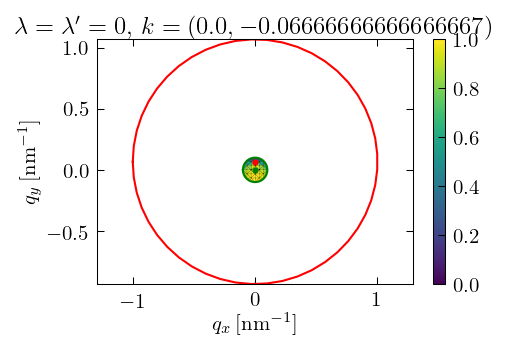

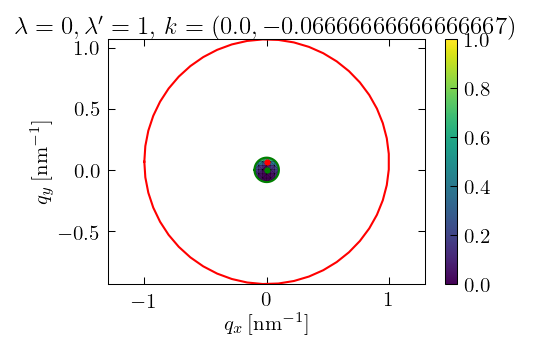

In [9]:
k_index = 10
theta = np.linspace(-np.pi,np.pi)
###Plot for \lambda=\lambda'
plt.figure(1)
plt.axes()
plt.axis('equal')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

valid_index = np.invert(np.isnan(density_matrix_kq2[0,0,k_index,:,0]))
plt.title(r'$\lambda=\lambda^\prime=0$, $k = ({},{})$'.format(
    *graphene.band_structure.k_sample.coords[k_index]))
plt.tripcolor(graphene.band_structure.q_sample.coords[valid_index,0],  
            graphene.band_structure.q_sample.coords[valid_index,1], 
            np.real(density_matrix_kq2[0,0,k_index,valid_index,0]), 
              vmin = 0., vmax = 1.)
plt.triplot(graphene.band_structure.q_sample.coords[valid_index,0],  
            graphene.band_structure.q_sample.coords[valid_index,1],lw=0.1,c='k')
plt.plot(q_cutoff * np.cos(theta), q_cutoff * np.sin(theta),'g')
plt.plot([0.], 
         [0.],'go')
plt.plot(k_cutoff * np.cos(theta)-graphene.band_structure.k_sample.coords[k_index,0], 
         k_cutoff * np.sin(theta)-graphene.band_structure.k_sample.coords[k_index,1],'r')
plt.plot([-graphene.band_structure.k_sample.coords[k_index,0]], 
         [-graphene.band_structure.k_sample.coords[k_index,1]],'ro')

cb = plt.colorbar()


###Plot for \lambda\neq\lambda'
plt.figure(2)
plt.axes()
plt.axis('equal')
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

valid_index = np.invert(np.isnan(density_matrix_kq2[0,1,k_index,:,0]))
plt.title(r'$\lambda=0,\lambda^\prime=1$, $k = ({},{})$'.format(
    *graphene.band_structure.k_sample.coords[k_index]))
plt.tripcolor(graphene.band_structure.q_sample.coords[valid_index,0],  
            graphene.band_structure.q_sample.coords[valid_index,1], 
            np.ma.masked_invalid(np.real(density_matrix_kq2[0,1,k_index,valid_index,0])),
             vmin = 0., vmax = 1.)

plt.triplot(graphene.band_structure.q_sample.coords[valid_index,0],  
            graphene.band_structure.q_sample.coords[valid_index,1],lw=0.1,c='k')
plt.plot(q_cutoff * np.cos(theta), q_cutoff * np.sin(theta),'g')
plt.plot([0.], 
         [0.],'go')
plt.plot(k_cutoff * np.cos(theta)-graphene.band_structure.k_sample.coords[k_index,0], 
         k_cutoff * np.sin(theta)-graphene.band_structure.k_sample.coords[k_index,1],'r')
plt.plot([-graphene.band_structure.k_sample.coords[k_index,0]], 
         [-graphene.band_structure.k_sample.coords[k_index,1]],'ro')

cb = plt.colorbar()


## The plot is for a fixed value of k in the x direction. The plot is in agreement with 
## the formula given some cells above

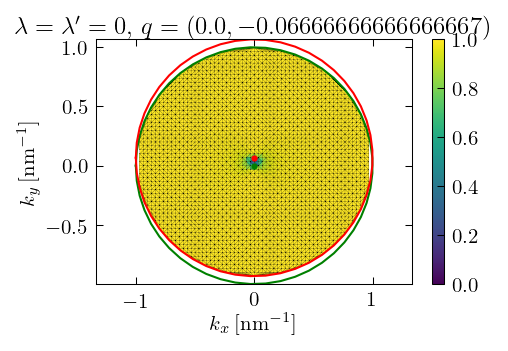

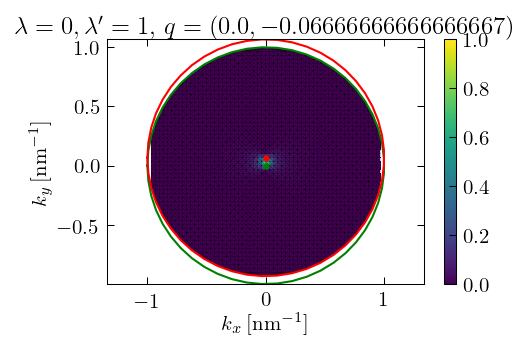

In [10]:
q_index = 10
theta = np.linspace(-np.pi,np.pi)
###Plot for \lambda=\lambda'
plt.figure(1)
plt.axes()
plt.axis('equal')
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')

valid_index = np.invert(np.isnan(density_matrix_kq2[0,0,:,q_index,0]))
plt.title(r'$\lambda=\lambda^\prime=0$, $q = ({},{})$'.format(
    *graphene.band_structure._q_sample.coords[q_index]))
plt.tripcolor(graphene.band_structure.k_sample.coords[valid_index,0],  
              graphene.band_structure.k_sample.coords[valid_index,1], 
              np.real(density_matrix_kq2[0,0,valid_index,q_index,0]), 
              vmin = 0., vmax = 1.)
plt.triplot(graphene.band_structure.k_sample.coords[valid_index,0],  
            graphene.band_structure.k_sample.coords[valid_index,1],lw=0.1,c='k')

plt.plot(k_cutoff * np.cos(theta), k_cutoff * np.sin(theta),'g')
plt.plot([0.], 
         [0.],'go')
plt.plot(k_cutoff * np.cos(theta)-graphene.band_structure.q_sample.coords[k_index,0], 
         k_cutoff * np.sin(theta)-graphene.band_structure.q_sample.coords[k_index,1],'r')
plt.plot([-graphene.band_structure.q_sample.coords[k_index,0]], 
         [-graphene.band_structure.q_sample.coords[k_index,1]],'ro')

cb = plt.colorbar()

###Plot for \lambda \neq \lambda'
plt.figure(2)
plt.axes()
plt.axis('equal')
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')

valid_index = np.invert(np.isnan(density_matrix_kq2[0,1,:,q_index,0]))
plt.title(r'$\lambda=0, \lambda^\prime=1$, $q = ({},{})$'.format(
    *graphene.band_structure._q_sample.coords[q_index]))
plt.tripcolor(graphene.band_structure.k_sample.coords[valid_index,0],  
              graphene.band_structure.k_sample.coords[valid_index,1], 
              np.real(density_matrix_kq2[0,1,valid_index,q_index,0]), 
              vmin = 0., vmax = 1.)
plt.triplot(graphene.band_structure.k_sample.coords[valid_index,0],  
            graphene.band_structure.k_sample.coords[valid_index,1],lw=0.1,c='k')

plt.plot(k_cutoff * np.cos(theta), k_cutoff * np.sin(theta),'g')
plt.plot([0.], 
         [0.],'go')
plt.plot(k_cutoff * np.cos(theta)-graphene.band_structure.q_sample.coords[k_index,0], 
         k_cutoff * np.sin(theta)-graphene.band_structure.q_sample.coords[k_index,1],'r')
plt.plot([-graphene.band_structure.q_sample.coords[k_index,0]], 
         [-graphene.band_structure.q_sample.coords[k_index,1]],'ro')

cb = plt.colorbar()

In [11]:
###SAVING###
####################### Output folder ##################################
output_folder = 'test_output/single_layer'
file_name = '/single_layer.hdf5'
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')

In [12]:
###IMPORTING###
band_structure_import = band_structure.from_file(file_name = output_folder + file_name, band_structure_name='band_structure', file_format="hdf5")

Space_Sample
Space_Sample
Sample


In [13]:
mask = np.isfinite(band_structure.density_matrix)
try:
    assert np.allclose(band_structure_import.density_matrix[mask], band_structure.density_matrix[mask])
except ValueError:
    print('The import of density_matrix is failed.')
'''
try:
    assert np.allclose(band_structure_import._q_sample, band_structure._q_sample)
except ValueError:
    print('The import of q_sample is failed.')
    

try:
    assert np.allclose(band_structure_import._G_sample, band_structure._G_sample)  
except ValueError:
    print('The import of G_sample is failed.')
'''

"\ntry:\n    assert np.allclose(band_structure_import._q_sample, band_structure._q_sample)\nexcept ValueError:\n    print('The import of q_sample is failed.')\n    \n\ntry:\n    assert np.allclose(band_structure_import._G_sample, band_structure._G_sample)  \nexcept ValueError:\n    print('The import of G_sample is failed.')\n"

## Dynamically change density, chemical potential or temperature

In [14]:
graphene.band_structure.chemical_potential=0.2
graphene.eta = 0.050

..\pybandstructure\band_structure\band_structure.py:609: UserWarning: changing chemical potential 
                         without changing band structure
  without changing band structure"""


## Calculate conductivity

In [15]:
omega_vals = np.linspace(0,1, num = 100)
sigma_vals = graphene.local_conductivity(omega_vals) # result in units of G_0, the quantum of conductance

..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


## Plot conductivity

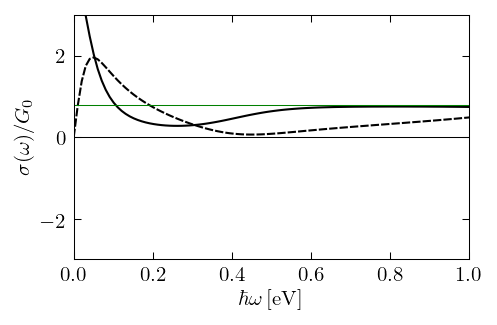

In [16]:
plt.xlabel(r'$\hbar \omega \, [{\rm eV}]$')
plt.ylabel(r'$\sigma(\omega)/G_0$')
plt.ylim(-3,3)
plt.plot(omega_vals,np.real(sigma_vals[:,0,0]),c='k') #note that sigma is a matrix, here I am selecting the xx component
plt.plot(omega_vals,np.imag(sigma_vals[:,0,0]),'--',c='k')

plt.plot(omega_vals,np.ones_like(omega_vals)*np.pi/4,'-', c='g', lw=0.5)
plt.plot(omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)
plt.savefig(output_folder +'/conductivity.pdf')